In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import torch
import data_loader
from traineval import train, evaluate
import model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load data

Each dataset [train:0.8, dev:0.1, test:0.1] consists of part the semcor dataset (https://www.gabormelli.com/RKB/SemCor_Corpus).

A sample is considered a single query word along with the sentence containing it. 

First, we load the datasets and use the train and dev ones for fitting and selecting a model. Note there is a special key for non labeled words - 'no_sense'.
The datasets loaded here (insatnces of torch.utils.data.Dataset) ignore these labels and will not serve them as samples to in training procedure.

* tokens_vocab - the sentence tokens vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with values of instance WSDDataset

In [3]:
datasets, tokens_vocab, y_vocab = data_loader.load(['train', 'dev'], sentence_count=100)
datasets['train']

Samples: 742 (no_sense: 0)
Sentences: 100 (N=76)
Vocab:
	Tokens:1663
	Senses:890

In [4]:
datasets['dev']

Samples: 589 (no_sense: 0)
Sentences: 100 (N=64)
Vocab:
	Tokens:1663
	Senses:890

# Implement and train an attention model

A few pointers:
* Use torch.nn.Embedding
* Both vocabularies have automatically added padding indexes 0.
* Initialize attention and embedding matrices with init.kaiming_uniform_
* Try to add dropout layers on embeddings or elsewhere
* Use layer norm instead of ReLU that was mentioned in the lecture
* A factor of $\frac{1}{\sqrt{D}}$ after multiplication of W_A might help convergence 

In [5]:
dropout = 0.2
D=300

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

In [6]:
lr=1e-3
batch_size=100
num_epochs=10

optimizer = torch.optim.Adam(m.parameters(), lr=lr, betas=(0.9, 0.999))

losses, train_acc, val_acc = train(
    m, optimizer, datasets['train'], datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

[9] loss: 0.481: 100%|██████████| 8/8 [00:00<00:00, 24.16it/s]


### Plot loss and train/val accuracy

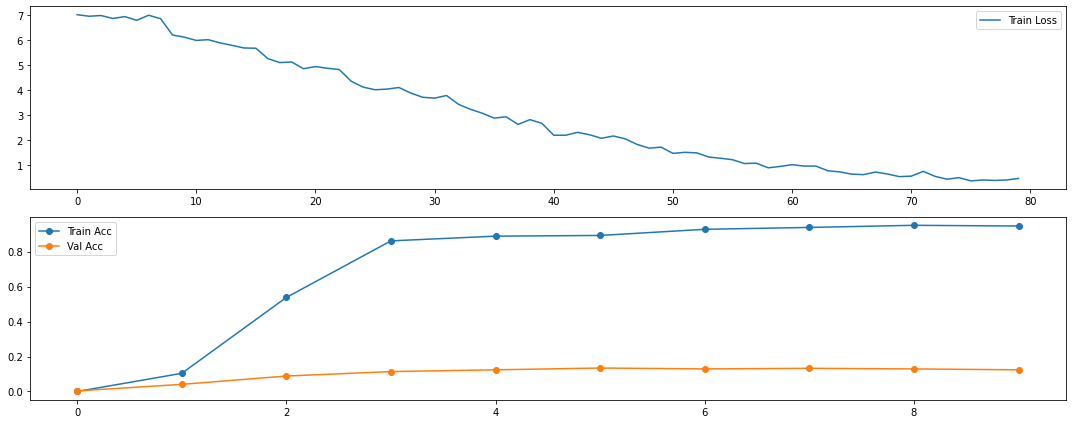

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

### Inspect attention

Each token in the sentence is numbered 0 - N.
The query token is highlighted green, attention with a pink - blue graident

In [8]:
from traineval import evaluate_verbose, highlight

import pandas as pd
import numpy as np

pd.set_option('max_columns', 100)

acc, eval_df, attention_df = evaluate_verbose(m, datasets['dev'], iter_lim=None)
idxs = np.where(eval_df['y_true'] == eval_df['y_pred'])
idxs = list(idxs[0][:10])
ev_styled, att_styled = highlight(eval_df, attention_df, idxs)
ev_styled

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
5,5,6,are,be.v.01,be.v.01,8.997e-01,0.105737,Readers,of,the,Reader,'s,Digest,are,familiar,with,such,items,which,often,appear,in,its,lists,of,verbal,slips,",",like,the,ad,in,a,California,paper,that,advertised,``,House,for,rent,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,17,1,said,state.v.01,state.v.01,9.276e-01,0.075158,He,said,the,matter,was,urgent,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,23,19,n't,n't.r.00,n't.r.00,8.856e-01,0.121474,Fundamentally,",",both,these,types,",",the,amateur,and,the,collector,",",are,uncritical,and,many,of,them,do,n't,distinguish,well,between,real,folklore,and,bogus,material,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34,34,2,Godot,person.n.01,person.n.01,2.776e-02,3.584037,Nothing,like,Godot,",",he,arrived,before,the,hour,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40,40,6,is,be.v.01,be.v.01,7.230e-01,0.324382,The,wardrobe,for,a,foreign,bomb,is,a,little,expensive,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54,54,24,put,put.v.01,put.v.01,2.396e-01,1.428608,As,he,went,out,he,told,Freddie,the,dinner,was,perfect,",",and,when,he,got,his,hat,and,coat,from,Nancy,Parks,and,put,a,fifty-piece,piece,in,the,slot,",",he,told,her,to,be,sure,that,it,went,toward,her,dowry,.,,,,,,,,,,,,,,,,,,,
64,64,2,had,have.v.01,have.v.01,3.626e-01,1.014341,This,arrangement,had,the,purpose,to,prevent,heated,gas,to,reach,the,thermocouple,by,natural,convection,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
77,77,8,was,be.v.01,be.v.01,7.901e-01,0.235596,Next,to,him,was,a,young,boy,I,was,sure,had,sat,near,me,at,one,of,the,trading,sessions,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81,81,9,was,be.v.01,be.v.01,8.077e-01,0.213623,As,he,went,out,he,told,Freddie,the,dinner,was,perfect,",",and,when,he,got,his,hat,and,coat,from,Nancy,Parks,and,put,a,fifty-piece,piece,in,the,slot,",",he,told,her,to,be,sure,that,it,went,toward,her,dowry,.,,,,,,,,,,,,,,,,,,,
88,88,3,have,have.v.01,have.v.01,6.596e-01,0.416123,Most,counties,also,have,maps,available,from,the,county,engineer,showing,roads,and,other,features,and,from,the,assessor,'s,office,showing,ownerships,of,land,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [9]:
# pd.set_option('max_rows', 20)
# eval_df.groupby('query_token').agg({
#     'query': 'count',
#     'y_true': 'nunique'
# }).sort_values(by='y_true')[-5:]

## Extend your model to implement self Attention

The method below converts the word level wsd datasets to sentence level datasets for a self attention model

In [10]:
sa_datasets = data_loader.WSDSentencesDataset.from_word_datasets(datasets)
sa_datasets['train']

Samples: 100
Sentences: 100 (N=76)
Vocab:
	Tokens:1663
	Senses:890

#### Imeplement and train

In [12]:
lr=1e-3
dropout = 0.2
D=300
batch_size=100
num_epochs=10

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    q_dim=sa_datasets['train'].N
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr, betas=(0.9, 0.999))

losses, train_acc, val_acc = train(
    m, optimizer, sa_datasets['train'], sa_datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

[9] loss: 2.545: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


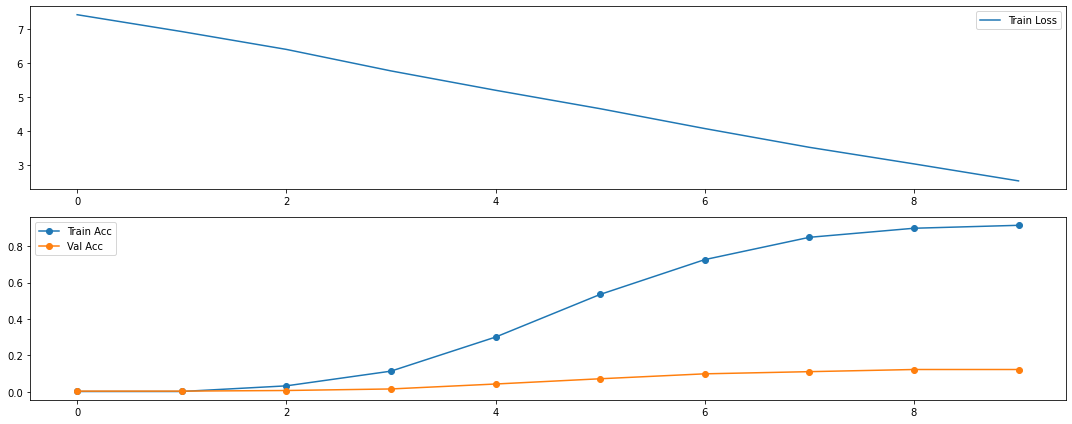

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()